RANDOM FOREST FOR BALANCE DATASET

In [1]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

In [3]:
# Load the dataset
df = pd.read_csv('/user/HS400/kb01548/Downloads/Balanced_hotel_data.csv')

# Separate features and target
X = df.drop(columns=['is_canceled'])
y = df['is_canceled']


Class Distribution:
0    0.5
1    0.5
Name: is_canceled, dtype: float64


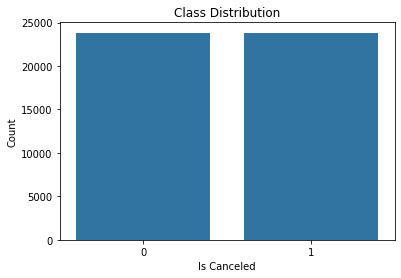

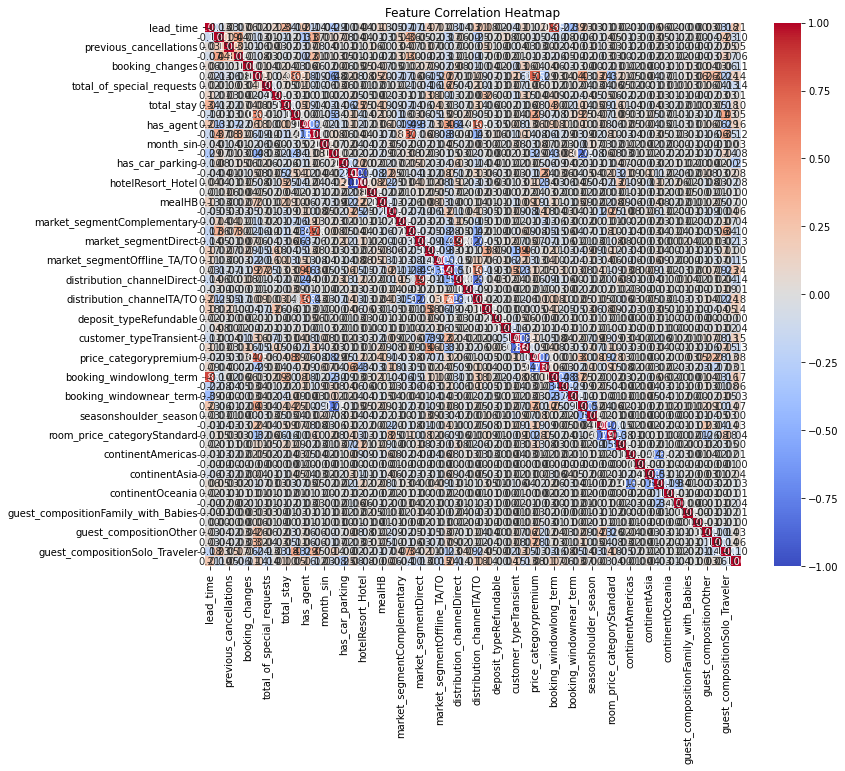


Correlation with Target Variable:
market_segmentOnline_TA                0.238017
lead_time                              0.208605
distribution_channelTA/TO              0.177818
booking_windowlong_term                0.166629
has_agent                              0.155816
customer_typeTransient                 0.148268
adr                                    0.141126
deposit_typeNon_Refund                 0.140465
total_stay                             0.098388
price_categorypremium                  0.077587
hotelCity_Hotel                        0.077209
seasonpeak_season                      0.071432
mealSC                                 0.063663
booking_windowmedium_term              0.063563
guest_compositionSmall_Family          0.057011
previous_cancellations                 0.054640
price_per_person                       0.052205
continentAsia                          0.042745
guest_compositionOther                 0.032819
room_price_categoryPremium             0.031865
month

In [4]:
print("\nClass Distribution:")
print(y.value_counts(normalize=True))
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title('Class Distribution')
plt.xlabel('Is Canceled')
plt.ylabel('Count')
plt.show()

# Correlation Analysis
# Calculate correlations between numerical features and the target variable
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

# Print correlation values with target variable
correlation_with_target = correlation_matrix['is_canceled'].drop('is_canceled').sort_values(ascending=False)
print("\nCorrelation with Target Variable:")
print(correlation_with_target)


In [5]:

# Split the dataset into training, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)


In [6]:
# Print sample counts
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")


Training samples: 30508
Validation samples: 7628
Test samples: 9534


In [7]:
print("Class Distribution in Training Set:")
print(y_train.value_counts(normalize=True))  
print("\nClass Distribution in Validation Set:")
print(y_val.value_counts(normalize=True))
print("\nClass Distribution in Test Set:")
print(y_test.value_counts(normalize=True))

Class Distribution in Training Set:
0    0.5
1    0.5
Name: is_canceled, dtype: float64

Class Distribution in Validation Set:
0    0.5
1    0.5
Name: is_canceled, dtype: float64

Class Distribution in Test Set:
0    0.5
1    0.5
Name: is_canceled, dtype: float64


In [8]:
# Random Forest Classifier and Hyperparameter Tuning
param_grid = {
    'n_estimators': [600, 700],        
    'max_depth': [40, 50, 60],        
    'min_samples_split': [10, 20, 30],  
    'min_samples_leaf': [5, 10, 20],    
    'max_features': ['sqrt']           
}

# Initialize the RandomForest Classifier
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Perform GridSearchCV on the training set 
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=1, scoring='recall', refit=True)  # Using recall as the scoring metric
grid_search.fit(X_train, y_train)

# Best Parameters and Model
best_rf = grid_search.best_estimator_
print("\nBest Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/user/HS400/kb01548/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Best Hyperparameters: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 700}


In [9]:
# Evaluate performance on the validation set 
y_val_pred = best_rf.predict(X_val)
val_recall = classification_report(y_val, y_val_pred, output_dict=True)['1']['recall']
print(f"\nValidation Recall: {val_recall:.2f}")
print("\nClassification Report (Validation):\n", classification_report(y_val, y_val_pred))
print("\nConfusion Matrix (Validation):\n", confusion_matrix(y_val, y_val_pred))


Validation Recall: 0.75

Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.75      0.77      0.76      3814
           1       0.77      0.75      0.76      3814

    accuracy                           0.76      7628
   macro avg       0.76      0.76      0.76      7628
weighted avg       0.76      0.76      0.76      7628


Confusion Matrix (Validation):
 [[2942  872]
 [ 970 2844]]


In [10]:
# Print the best cross-validation score
best_cv_score = grid_search.best_score_
print(f"\nBest Cross-Validation Score: {best_cv_score:.2f}")


Best Cross-Validation Score: 0.75


In [11]:
#  Evaluate performance on the training set
y_train_pred = best_rf.predict(X_train)  
train_accuracy = accuracy_score(y_train, y_train_pred)  
train_report = classification_report(y_train, y_train_pred)  

print(f"\nTraining Accuracy: {train_accuracy:.2f}")
print("\nClassification Report (Training):\n", train_report)


Training Accuracy: 0.84

Classification Report (Training):
               precision    recall  f1-score   support

           0       0.84      0.83      0.84     15254
           1       0.83      0.84      0.84     15254

    accuracy                           0.84     30508
   macro avg       0.84      0.84      0.84     30508
weighted avg       0.84      0.84      0.84     30508




Test Accuracy: 0.76

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.76      0.77      0.76      4767
           1       0.76      0.76      0.76      4767

    accuracy                           0.76      9534
   macro avg       0.76      0.76      0.76      9534
weighted avg       0.76      0.76      0.76      9534


Confusion Matrix (Test):
 [[3648 1119]
 [1127 3640]]


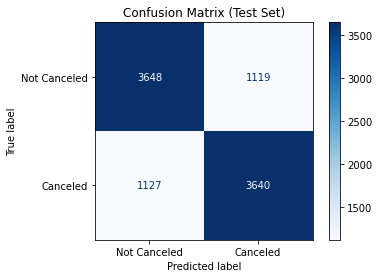

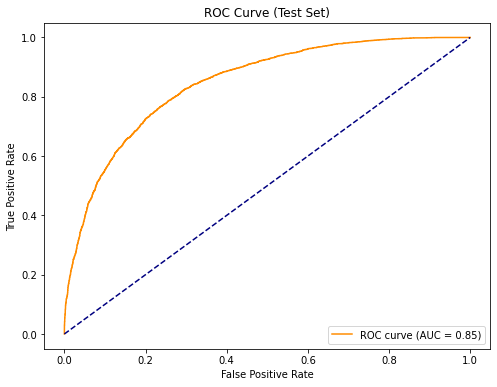

In [12]:
#  Predict on the test set
y_test_pred = best_rf.predict(X_test)  

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)  
test_report = classification_report(y_test, y_test_pred) 
test_conf_matrix = confusion_matrix(y_test, y_test_pred)  

print(f"\nTest Accuracy: {test_accuracy:.2f}")
print("\nClassification Report (Test):\n", test_report)
print("\nConfusion Matrix (Test):\n", test_conf_matrix)

# Plot the confusion matrix for test set
ConfusionMatrixDisplay(test_conf_matrix, display_labels=['Not Canceled', 'Canceled']).plot(cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Step 7: ROC Curve and AUC
y_pred_prob = best_rf.predict_proba(X_test)[:, 1]  
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend(loc="lower right")
plt.show()

RANDOM FOREST FOR IMBALANCE DATASET

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

In [14]:
# Load the dataset
df = pd.read_csv('/user/HS400/kb01548/Downloads/Unbalanced_hotel_data.csv')
X = df.drop(columns=['is_canceled'])
y = df['is_canceled']


Class Distribution:
0    0.722859
1    0.277141
Name: is_canceled, dtype: float64


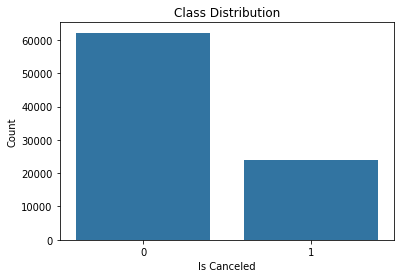

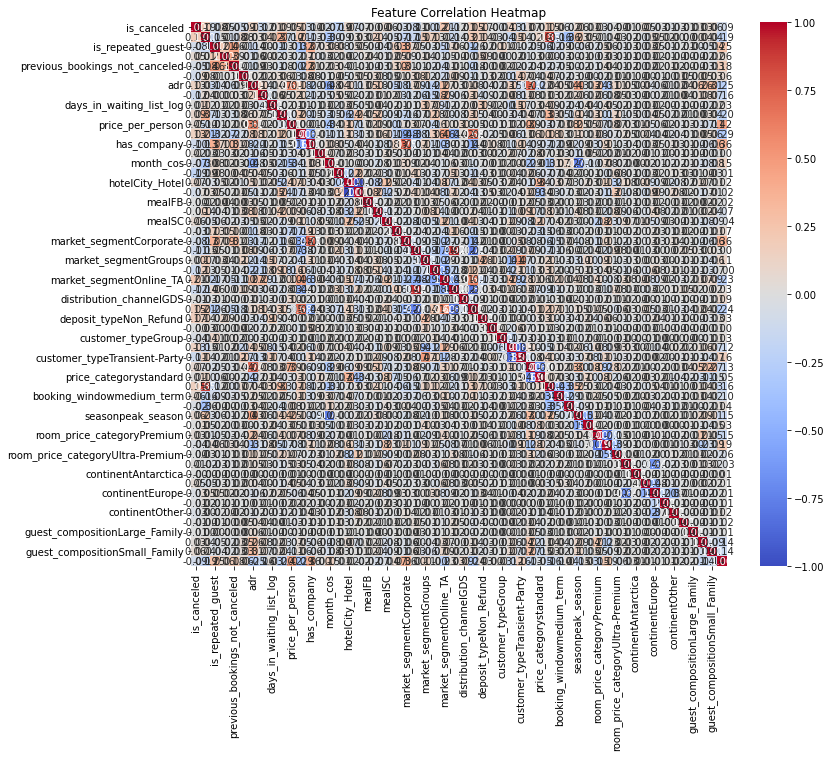


Correlation with Target Variable:
market_segmentOnline_TA                0.211727
lead_time                              0.187364
deposit_typeNon_Refund                 0.165329
distribution_channelTA/TO              0.152673
booking_windowlong_term                0.150273
has_agent                              0.133506
customer_typeTransient                 0.127406
adr                                    0.127006
total_stay                             0.086919
hotelCity_Hotel                        0.071243
price_categorypremium                  0.069755
seasonpeak_season                      0.064428
booking_windowmedium_term              0.059817
guest_compositionSmall_Family          0.058250
mealSC                                 0.058104
previous_cancellations                 0.050861
continentAsia                          0.048190
price_per_person                       0.046157
room_price_categoryPremium             0.031783
guest_compositionOther                 0.029380
month

In [15]:
#Check for class balance
print("\nClass Distribution:")
print(y.value_counts(normalize=True))
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title('Class Distribution')
plt.xlabel('Is Canceled')
plt.ylabel('Count')
plt.show()

# Correlation Analysis
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

# Print correlation values with target variable
correlation_with_target = correlation_matrix['is_canceled'].drop('is_canceled').sort_values(ascending=False)
print("\nCorrelation with Target Variable:")
print(correlation_with_target)


In [16]:

# Step 1: Split the dataset into training, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)


In [17]:
# Print sample counts
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")


Training samples: 55041
Validation samples: 13761
Test samples: 17201


In [18]:
print("Class Distribution in Training Set:")
print(y_train.value_counts(normalize=True))  
print("\nClass Distribution in Validation Set:")
print(y_val.value_counts(normalize=True))
print("\nClass Distribution in Test Set:")
print(y_test.value_counts(normalize=True))

Class Distribution in Training Set:
0    0.722861
1    0.277139
Name: is_canceled, dtype: float64

Class Distribution in Validation Set:
0    0.72284
1    0.27716
Name: is_canceled, dtype: float64

Class Distribution in Test Set:
0    0.722865
1    0.277135
Name: is_canceled, dtype: float64


In [19]:
# Random Forest Classifier and Hyperparameter Tuning
param_grid = {
    'n_estimators': [600, 700],        
    'max_depth': [40, 50, 60],        
    'min_samples_split': [10, 20, 30],  
    'min_samples_leaf': [5, 10, 20],    
    'max_features': ['sqrt']           
}

# Initialize the RandomForest Classifier
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Perform GridSearchCV on the training set (uses validation set for evaluation)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=1, scoring='recall', refit=True)  
grid_search.fit(X_train, y_train)

#  Best Parameters and Model
best_rf = grid_search.best_estimator_
print("\nBest Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best Hyperparameters: {'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 600}


In [20]:
# Evaluate performance on the validation set 
y_val_pred = best_rf.predict(X_val)
val_recall = classification_report(y_val, y_val_pred, output_dict=True)['1']['recall']
print(f"\nValidation Recall: {val_recall:.2f}")
print("\nClassification Report (Validation):\n", classification_report(y_val, y_val_pred))
print("\nConfusion Matrix (Validation):\n", confusion_matrix(y_val, y_val_pred))


Validation Recall: 0.74

Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.88      0.77      0.82      9947
           1       0.55      0.74      0.63      3814

    accuracy                           0.76     13761
   macro avg       0.72      0.75      0.73     13761
weighted avg       0.79      0.76      0.77     13761


Confusion Matrix (Validation):
 [[7691 2256]
 [1009 2805]]


In [21]:
# Print the best cross-validation score
best_cv_score = grid_search.best_score_
print(f"\nBest Cross-Validation Score: {best_cv_score:.2f}")


Best Cross-Validation Score: 0.74


In [22]:
#  Evaluate performance on the training set
y_train_pred = best_rf.predict(X_train)  
train_accuracy = accuracy_score(y_train, y_train_pred)  
train_report = classification_report(y_train, y_train_pred)  

print(f"\nTraining Accuracy: {train_accuracy:.2f}")
print("\nClassification Report (Training):\n", train_report)


Training Accuracy: 0.79

Classification Report (Training):
               precision    recall  f1-score   support

           0       0.91      0.79      0.84     39787
           1       0.59      0.79      0.67     15254

    accuracy                           0.79     55041
   macro avg       0.75      0.79      0.76     55041
weighted avg       0.82      0.79      0.80     55041




Test Accuracy: 0.76

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.88      0.77      0.82     12434
           1       0.55      0.73      0.63      4767

    accuracy                           0.76     17201
   macro avg       0.72      0.75      0.72     17201
weighted avg       0.79      0.76      0.77     17201


Confusion Matrix (Test):
 [[9579 2855]
 [1284 3483]]


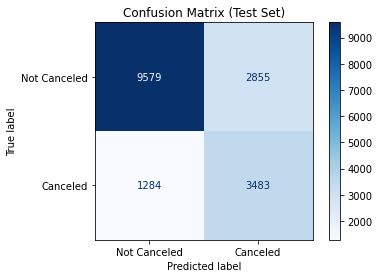

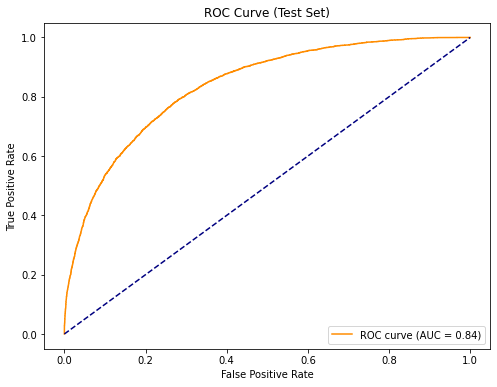

In [23]:
#Predict on the test set
y_test_pred = best_rf.predict(X_test)  

#  Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)  
test_report = classification_report(y_test, y_test_pred)  
test_conf_matrix = confusion_matrix(y_test, y_test_pred)  

print(f"\nTest Accuracy: {test_accuracy:.2f}")
print("\nClassification Report (Test):\n", test_report)
print("\nConfusion Matrix (Test):\n", test_conf_matrix)

# Plot the confusion matrix for test set
ConfusionMatrixDisplay(test_conf_matrix, display_labels=['Not Canceled', 'Canceled']).plot(cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# ROC Curve and AUC
y_pred_prob = best_rf.predict_proba(X_test)[:, 1]  
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend(loc="lower right")
plt.show()

XGBOOOST FOR BALANCE DATASET

In [110]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [156]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

In [157]:
# Load the dataset
df = pd.read_csv('/user/HS400/kb01548/Downloads/Balanced_hotel_data.csv')
X = df.drop(columns=['is_canceled'])
y = df['is_canceled']



Class Distribution:
0    0.5
1    0.5
Name: is_canceled, dtype: float64


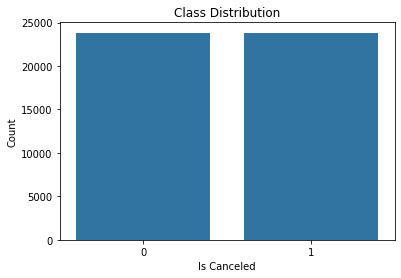

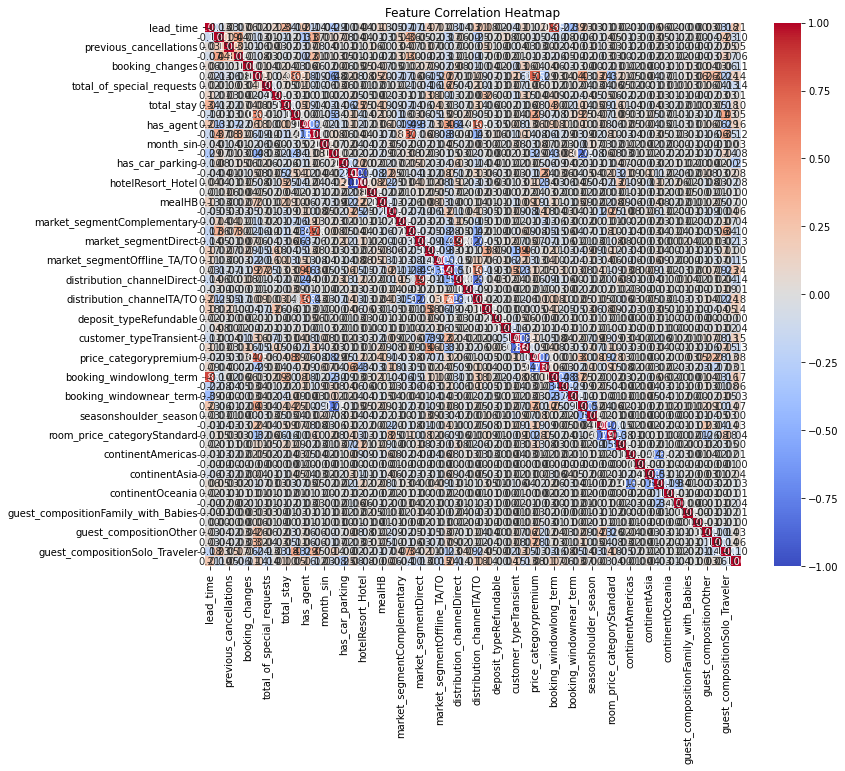


Correlation with Target Variable:
market_segmentOnline_TA                0.238017
lead_time                              0.208605
distribution_channelTA/TO              0.177818
booking_windowlong_term                0.166629
has_agent                              0.155816
customer_typeTransient                 0.148268
adr                                    0.141126
deposit_typeNon_Refund                 0.140465
total_stay                             0.098388
price_categorypremium                  0.077587
hotelCity_Hotel                        0.077209
seasonpeak_season                      0.071432
mealSC                                 0.063663
booking_windowmedium_term              0.063563
guest_compositionSmall_Family          0.057011
previous_cancellations                 0.054640
price_per_person                       0.052205
continentAsia                          0.042745
guest_compositionOther                 0.032819
room_price_categoryPremium             0.031865
month

In [158]:
# Check for class balance
print("\nClass Distribution:")
print(y.value_counts(normalize=True))
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title('Class Distribution')
plt.xlabel('Is Canceled')
plt.ylabel('Count')
plt.show()

# Correlation Analysis
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

# Print correlation values with target variable
correlation_with_target = correlation_matrix['is_canceled'].drop('is_canceled').sort_values(ascending=False)
print("\nCorrelation with Target Variable:")
print(correlation_with_target)

In [159]:
#  Split the dataset into training, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Training samples: 30508
Validation samples: 7628
Test samples: 9534


In [160]:
#  XGBoost Classifier and Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200],       
    'max_depth': [2, 3],               
    'learning_rate': [0.01, 0.1, 0.2],   
    'subsample': [1.0, 1.2, 1.4],             
    'colsample_bytree': [1.0, 1.2, 1.4]        
}

# Initialize the XGBoost Classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Perform GridSearchCV on the training set 
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=1, scoring='accuracy', refit=True)  
grid_search.fit(X_train, y_train)

#  Best Parameters and Model
best_xgb = grid_search.best_estimator_
print("\nBest Hyperparameters:", grid_search.best_params_)

# Print the best cross-validation score
best_cv_score = grid_search.best_score_
print(f"\nBest Cross-Validation Score: {best_cv_score:.2f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/user/HS400/kb01548/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:30:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/user/HS400/kb01548/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:30:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/user/HS400/kb01548/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:30:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/user/HS400/kb01548/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:30:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/user/HS400/kb01548/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning


Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}

Best Cross-Validation Score: 0.75



Validation Accuracy: 0.75

Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.75      0.75      0.75      3814
           1       0.75      0.75      0.75      3814

    accuracy                           0.75      7628
   macro avg       0.75      0.75      0.75      7628
weighted avg       0.75      0.75      0.75      7628


Confusion Matrix (Validation):
 [[2868  946]
 [ 952 2862]]


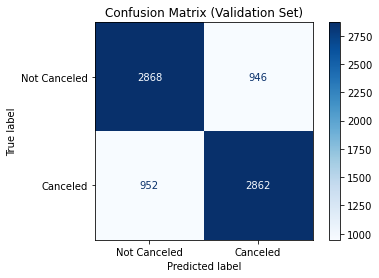

In [161]:
# Evaluate performance on the validation set 
y_val_pred = best_xgb.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_report = classification_report(y_val, y_val_pred)
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

print(f"\nValidation Accuracy: {val_accuracy:.2f}")
print("\nClassification Report (Validation):\n", val_report)
print("\nConfusion Matrix (Validation):\n", val_conf_matrix)

# Plot the confusion matrix for validation set
ConfusionMatrixDisplay(val_conf_matrix, display_labels=['Not Canceled', 'Canceled']).plot(cmap='Blues')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

In [162]:
#  Evaluate performance on the training set
y_train_pred = best_xgb.predict(X_train)  
train_accuracy = accuracy_score(y_train, y_train_pred)  
train_report = classification_report(y_train, y_train_pred) 

print(f"\nTraining Accuracy: {train_accuracy:.2f}")
print("\nClassification Report (Training):\n", train_report)

# Predict on the test set
y_test_pred = best_xgb.predict(X_test)  



Training Accuracy: 0.77

Classification Report (Training):
               precision    recall  f1-score   support

           0       0.77      0.76      0.77     15254
           1       0.76      0.77      0.77     15254

    accuracy                           0.77     30508
   macro avg       0.77      0.77      0.77     30508
weighted avg       0.77      0.77      0.77     30508




Test Accuracy: 0.76

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.76      0.75      0.75      4767
           1       0.75      0.76      0.76      4767

    accuracy                           0.76      9534
   macro avg       0.76      0.76      0.76      9534
weighted avg       0.76      0.76      0.76      9534


Confusion Matrix (Test):
 [[3565 1202]
 [1131 3636]]


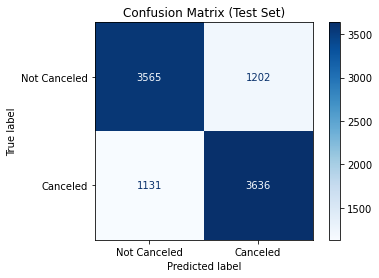

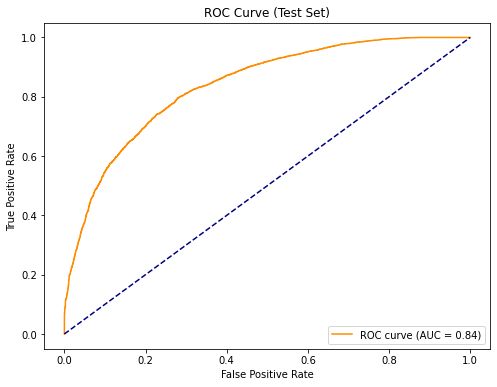

In [163]:
#Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)  
test_report = classification_report(y_test, y_test_pred)  
test_conf_matrix = confusion_matrix(y_test, y_test_pred)  

print(f"\nTest Accuracy: {test_accuracy:.2f}")
print("\nClassification Report (Test):\n", test_report)
print("\nConfusion Matrix (Test):\n", test_conf_matrix)

# Plot the confusion matrix for test set
ConfusionMatrixDisplay(test_conf_matrix, display_labels=['Not Canceled', 'Canceled']).plot(cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Step 7: ROC Curve and AUC
y_pred_prob = best_xgb.predict_proba(X_test)[:, 1]  
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend(loc="lower right")
plt.show()


XGBOOOST FOR IMBALANCE DATASET

In [164]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

In [165]:
# Load the dataset
df = pd.read_csv('/user/HS400/kb01548/Downloads/Unbalanced_hotel_data.csv')

# Separate features and target
X = df.drop(columns=['is_canceled'])
y = df['is_canceled']



Class Distribution:
0    0.722859
1    0.277141
Name: is_canceled, dtype: float64


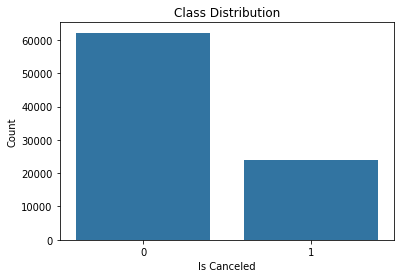

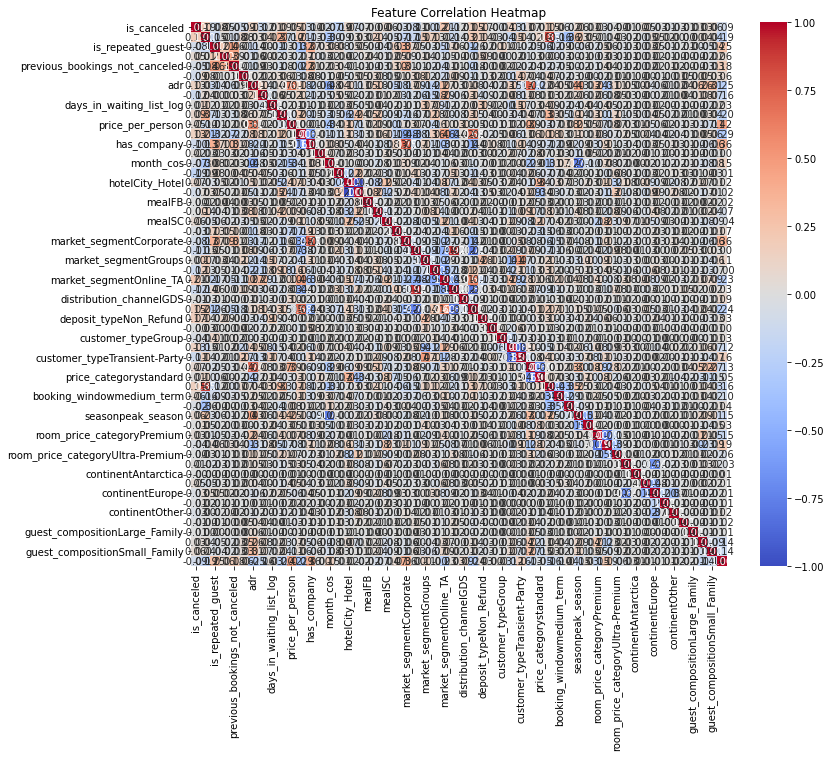


Correlation with Target Variable:
market_segmentOnline_TA                0.211727
lead_time                              0.187364
deposit_typeNon_Refund                 0.165329
distribution_channelTA/TO              0.152673
booking_windowlong_term                0.150273
has_agent                              0.133506
customer_typeTransient                 0.127406
adr                                    0.127006
total_stay                             0.086919
hotelCity_Hotel                        0.071243
price_categorypremium                  0.069755
seasonpeak_season                      0.064428
booking_windowmedium_term              0.059817
guest_compositionSmall_Family          0.058250
mealSC                                 0.058104
previous_cancellations                 0.050861
continentAsia                          0.048190
price_per_person                       0.046157
room_price_categoryPremium             0.031783
guest_compositionOther                 0.029380
month

In [166]:
# Check for class balance
print("\nClass Distribution:")
print(y.value_counts(normalize=True))
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title('Class Distribution')
plt.xlabel('Is Canceled')
plt.ylabel('Count')
plt.show()

# Correlation Analysis
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

# Print correlation values with target variable
correlation_with_target = correlation_matrix['is_canceled'].drop('is_canceled').sort_values(ascending=False)
print("\nCorrelation with Target Variable:")
print(correlation_with_target)

In [167]:
#  Split the dataset into training, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

# Print sample counts
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Training samples: 55041
Validation samples: 13761
Test samples: 17201


In [168]:
#  XGBoost Classifier and Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],        
    'max_depth': [3, 5, 7],               
    'learning_rate': [0.01, 0.1, 0.2],    
    'subsample': [0.8, 1.0],             
    'colsample_bytree': [0.8, 1.0]        
}

# Initialize the XGBoost Classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Perform GridSearchCV on the training set 
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=1, scoring='accuracy', refit=True)  
grid_search.fit(X_train, y_train)

# Step 3: Best Parameters and Model
best_xgb = grid_search.best_estimator_
print("\nBest Hyperparameters:", grid_search.best_params_)

# Print the best cross-validation score
best_cv_score = grid_search.best_score_
print(f"\nBest Cross-Validation Score: {best_cv_score:.2f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/user/HS400/kb01548/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:32:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/user/HS400/kb01548/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:32:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/user/HS400/kb01548/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:32:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/user/HS400/kb01548/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:32:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/user/HS400/kb01548/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning


Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}

Best Cross-Validation Score: 0.81



Validation Accuracy: 0.81

Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.84      0.92      0.88      9947
           1       0.73      0.53      0.61      3814

    accuracy                           0.81     13761
   macro avg       0.78      0.73      0.74     13761
weighted avg       0.81      0.81      0.80     13761


Confusion Matrix (Validation):
 [[9190  757]
 [1801 2013]]


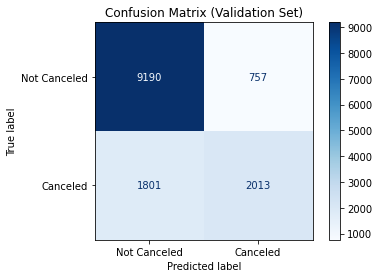

In [169]:
# Evaluate performance on the validation set (to confirm hyperparameter tuning)
y_val_pred = best_xgb.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_report = classification_report(y_val, y_val_pred)
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

print(f"\nValidation Accuracy: {val_accuracy:.2f}")
print("\nClassification Report (Validation):\n", val_report)
print("\nConfusion Matrix (Validation):\n", val_conf_matrix)

# Plot the confusion matrix for validation set
ConfusionMatrixDisplay(val_conf_matrix, display_labels=['Not Canceled', 'Canceled']).plot(cmap='Blues')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

In [170]:
# Evaluate performance on the training set
y_train_pred = best_xgb.predict(X_train)  
train_accuracy = accuracy_score(y_train, y_train_pred)  
train_report = classification_report(y_train, y_train_pred)  

print(f"\nTraining Accuracy: {train_accuracy:.2f}")
print("\nClassification Report (Training):\n", train_report)

#  Predict on the test set
y_test_pred = best_xgb.predict(X_test)  



Training Accuracy: 0.85

Classification Report (Training):
               precision    recall  f1-score   support

           0       0.86      0.94      0.90     39787
           1       0.80      0.60      0.69     15254

    accuracy                           0.85     55041
   macro avg       0.83      0.77      0.79     55041
weighted avg       0.84      0.85      0.84     55041




Test Accuracy: 0.81

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.83      0.92      0.87     12434
           1       0.71      0.52      0.60      4767

    accuracy                           0.81     17201
   macro avg       0.77      0.72      0.74     17201
weighted avg       0.80      0.81      0.80     17201


Confusion Matrix (Test):
 [[11438   996]
 [ 2277  2490]]


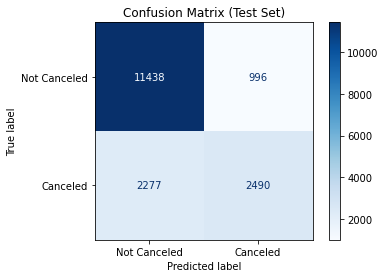

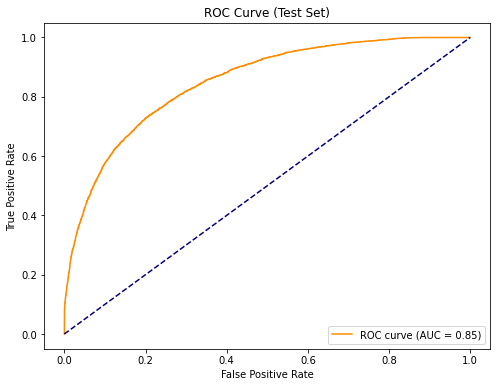

In [171]:
#  Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)  
test_report = classification_report(y_test, y_test_pred)  
test_conf_matrix = confusion_matrix(y_test, y_test_pred)  

print(f"\nTest Accuracy: {test_accuracy:.2f}")
print("\nClassification Report (Test):\n", test_report)
print("\nConfusion Matrix (Test):\n", test_conf_matrix)

# Plot the confusion matrix for test set
ConfusionMatrixDisplay(test_conf_matrix, display_labels=['Not Canceled', 'Canceled']).plot(cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.show()

#  ROC Curve and AUC
y_pred_prob = best_xgb.predict_proba(X_test)[:, 1]  
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend(loc="lower right")
plt.show()
